# Notebook from FP, QAT to hls for higher total bits(16, 14, 12, 10)

## There are three phases for QAT

1. FP model training
2. Encoder quantized only QAT
3. Full quantized model QAT

In [1]:
# total bit setting
total_bit = 16

# Set to True to do phase 1, otherwise load the previous saved model
retrain_fp_model = False
# Set to True to do phase 2, otherwise load the previous saved model
encoder_quantized_only_retrain = True
# Set to True to do phase 3, otherwise load the previous saved model
all_quantized_retrain = True

# hls model output directory and precision setting
hls_model_output_dir  = './hls_model/lfad_qmodel_' + str(total_bit)
hls_default_precision = 'ap_fixed<22,6>'

In [2]:
%config Completer.use_jedi = False

import sys
sys.path.append('..')

import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Set environment variable for deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

use_cpu = False
cuda_device = '0'

if use_cpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    os.environ['CPU_ONLY'] = "TRUE"
    physical_devices = tf.config.list_physical_devices('CPU')
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration() for i in range(8)])
    logical_devices = tf.config.list_logical_devices('CPU')

    print(logical_devices)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = cuda_device
    os.environ['CPU_ONLY'] = "FALSE"
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime, ModelType
from tndm.utils import AdaptiveWeights
from tndm.models.model_loader import ModelLoader

from sklearn.linear_model import Ridge

from plotting import *

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

# test set is combined valid and test
neural_data = dataset['train_data'].astype('float')
valid_neural_data = dataset['valid_data'].astype('float')
test_neural_data = dataset['test_data'].astype('float')

behavioural_data = dataset['train_behaviours'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# for plotting
d_all = np.concatenate((dataset['train_target_direction'], dataset['test_target_direction'], dataset['valid_target_direction']))
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d_all)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

In [4]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [5]:
logdir = os.path.join( spike_data_dir, 'lfads_log_fp')
modeldir = os.path.join( spike_data_dir, 'lfads_model_fp')

In [6]:
T0 = datetime.now()

fp_model, x, y, validation_data, callbacks, adaptive_weights = Runtime.get_model(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed,
        quantized=False
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1000, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)


INFO:tndm.utils.logging:Seed was set to 0


Seed was set to 0


In [ ]:
if retrain_fp_model:
    history = fp_model.fit(
        x=x,
        y=y,
        callbacks=callbacks,
        shuffle=True,
        epochs=1000,
        batch_size=16,
        validation_data=validation_data,
        verbose=2
    )

    fp_model.save(modeldir)

    print('Training took '+str(datetime.now()-T0))

Epoch 1/1000


/home/pcslab/anaconda3/envs/lfads_hls4ml/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 - 1s - loss: 2873.5090 - loss/loglike: 2870.9590 - loss/kldiv: 12.7445 - loss/reg: 63.1764 - loss/reconstruction: 2870.9590 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0020 - learning_rate: 0.0100 - val_loss: 2571.5999 - val_loss/loglike: 2570.1760 - val_loss/kldiv: 7.1192 - val_loss/reconstruction: 2570.1760 - lr: 0.0100 - 1s/epoch - 119ms/step
Epoch 2/1000
9/9 - 1s - loss: 2479.9949 - loss/loglike: 2477.0669 - loss/kldiv: 14.6220 - loss/reg: 72.1879 - loss/reconstruction: 2477.0669 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0065 - learning_rate: 0.0100 - val_loss: 2308.9209 - val_loss/loglike: 2306.9419 - val_loss/kldiv: 9.8952 - val_loss/reconstruction: 2306.9419 - lr: 0.0100 - 504ms/epoch - 56ms/step
Epoch 3/1000
9/9 - 1s - loss: 2239.3723 - loss/loglike: 2236.9548 - loss/kldiv: 12.0545 - loss/reg: 78.6974 - loss/reconstruction: 2236.9548 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0110 - learning_rate: 0.010

In [9]:
print(modeldir)
fp_model = ModelLoader.load(modeldir, model_class=LFADS)

Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_fp


# Latent space

## Training data

In [10]:
log_f, (g0, mean, logvar), z =  fp_model(neural_data.astype('float'), training=False)

Text(0.5, 1.0, 'Factors')

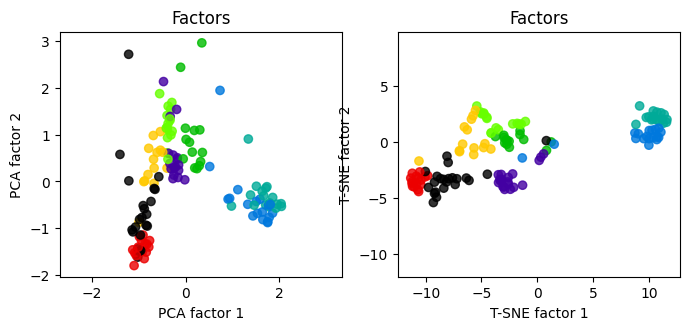

In [11]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


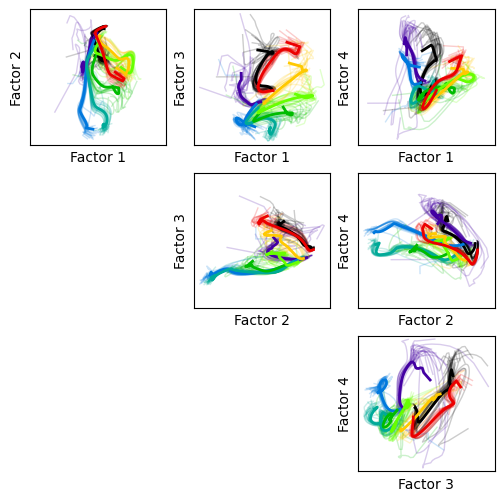

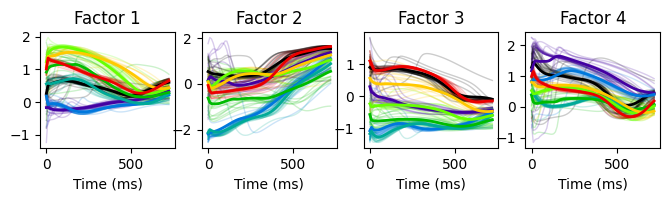

In [12]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [13]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

0.9180981710417347


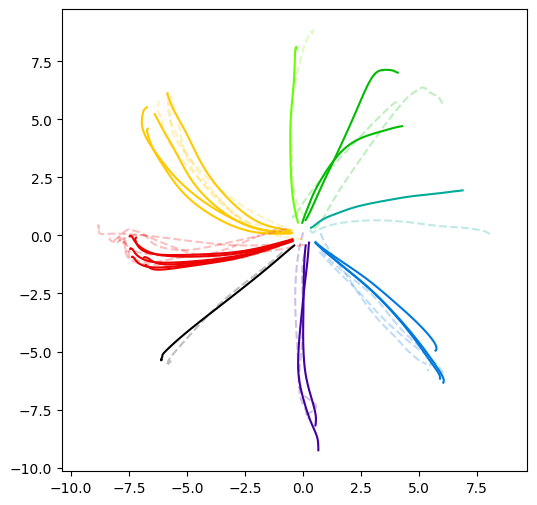

In [14]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [15]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 91.810%


## Test data

In [16]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    fp_model(test_neural_data.astype('float'), training=False)

Text(0.5, 1.0, 'Factors')

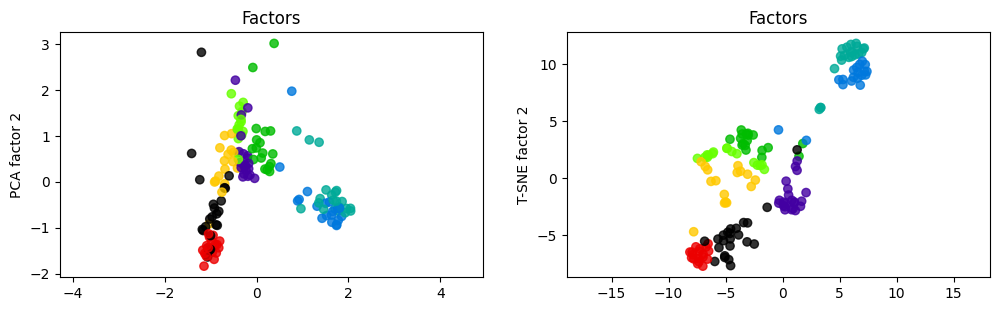

In [17]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


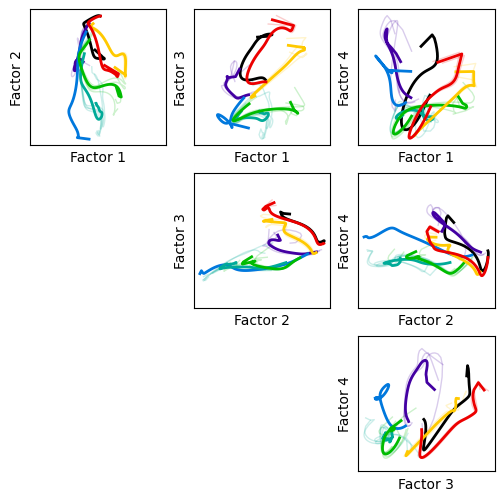

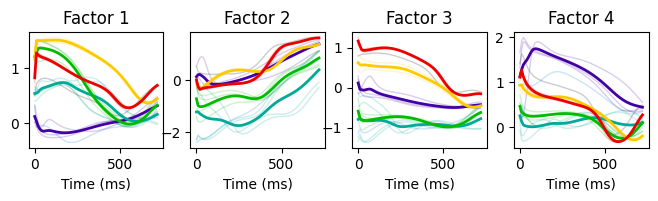

In [18]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [19]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

0.9233394116196616


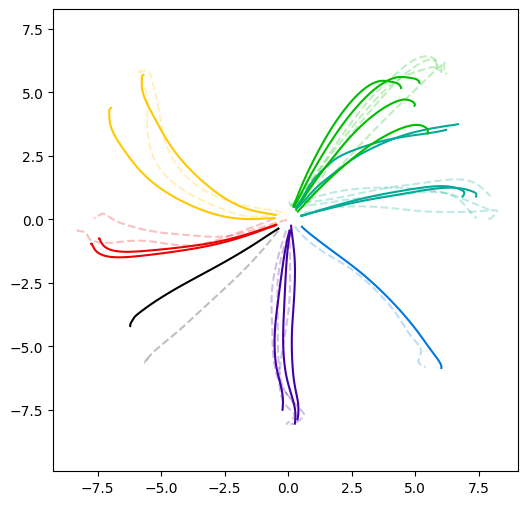

In [20]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [21]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 92.334%


# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

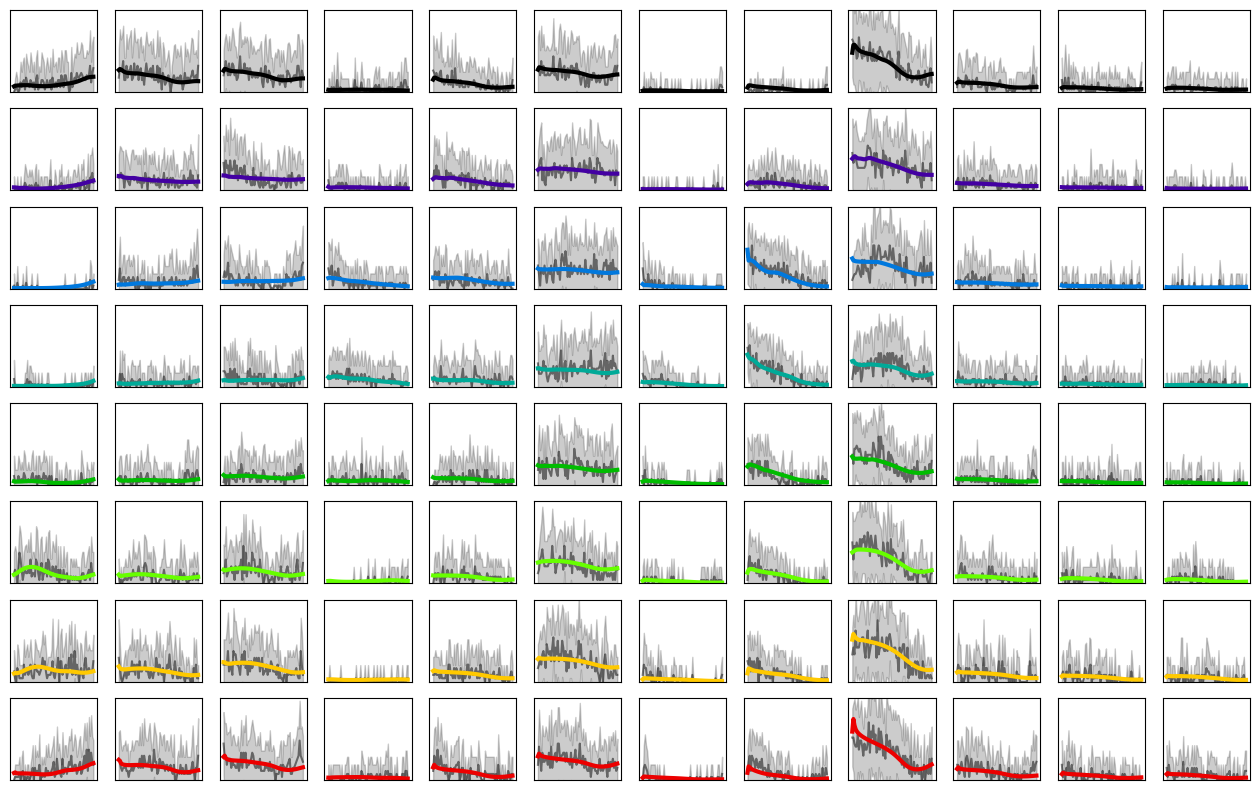

In [22]:
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]
    
    for i_n,n in enumerate(range(0,12)):
        ax = fig.add_subplot(8, 12, i*12+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
    

In [23]:
fp_model.summary()

Model: "lfads_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 EncoderRNN (Bidirectional)  multiple                  52224     
                                                                 
 dropout_7 (Dropout)         multiple                  0         
                                                                 
 dropout_8 (Dropout)         multiple                  0         
                                                                 
 DenseMean (Dense)           multiple                  8256      
                                                                 
 DenseLogVar (Dense)         multiple                  8256      
                                                                 
 GaussianSampling (GaussianS  multiple                 0   

In [24]:
fp_model.quantized

False

# Encoder Quantized Only QAT

In [25]:
# encoder only qat model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [26]:
logdir = os.path.join( spike_data_dir, 'lfads_log_'+str(total_bit)+'_encoder_quantized_only')
modeldir = os.path.join( spike_data_dir, 'lfads_model_'+str(total_bit)+'_encoder_quantized_only')

In [27]:
T0 = datetime.now()

en_qat_model, x, y, validation_data, callbacks, adaptive_weights = Runtime.get_model(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-6),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed,
        encoder_quantized=True,
        total_bit=total_bit
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1000, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)

en_qat_model.load_model_weight(fp_model)

# freeze all the other layers except encoder

lfads_layers = [
    # encoder
    #"initial_dropout",
    #"encoder",
    #"dropout_post_encoder",
    "dense_mean",
    "dense_logvar",
    #"sampling",
    
    # decoder    
    "decoder",
    #"dropout_post_decoder",
    "dense",
    "neural_dense"
]

if encoder_quantized_only_retrain:
    # Set specified layers as non-trainable
    for layer_attr in lfads_layers:
        layer = getattr(en_qat_model, layer_attr, None)
        if layer is not None:
            layer.trainable = False
            print(layer_attr ," is setted as non-trainable")
        else:
            print(layer_attr ," is not found")

    history = en_qat_model.fit(
        x=x,
        y=y,
        callbacks=callbacks,
        shuffle=True,
        epochs=200,
        batch_size=16,
        validation_data=validation_data,
        verbose=2
    )

    en_qat_model.save(modeldir)

    print('Training took '+str(datetime.now()-T0))

INFO:tndm.utils.logging:Seed was set to 0


Seed was set to 0
dense_mean  is setted as non-trainable
dense_logvar  is setted as non-trainable
decoder  is setted as non-trainable
dense  is setted as non-trainable
neural_dense  is setted as non-trainable
Epoch 1/200


/home/pcslab/anaconda3/envs/lfads_hls4ml/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 - 21s - loss: 1802.7928 - loss/loglike: 1801.2832 - loss/kldiv: 7.5391 - loss/reg: 115.7330 - loss/reconstruction: 1801.2832 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0020 - learning_rate: 0.0010 - val_loss: 1799.7239 - val_loss/loglike: 1798.6611 - val_loss/kldiv: 5.3130 - val_loss/reconstruction: 1798.6611 - lr: 0.0010 - 21s/epoch - 2s/step
Epoch 2/200
9/9 - 21s - loss: 1795.3875 - loss/loglike: 1793.6637 - loss/kldiv: 8.5917 - loss/reg: 114.8072 - loss/reconstruction: 1793.6637 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0065 - learning_rate: 0.0010 - val_loss: 1796.3115 - val_loss/loglike: 1795.1805 - val_loss/kldiv: 5.6557 - val_loss/reconstruction: 1795.1805 - lr: 0.0010 - 21s/epoch - 2s/step
Epoch 3/200
9/9 - 21s - loss: 1788.6008 - loss/loglike: 1786.8181 - loss/kldiv: 8.8675 - loss/reg: 114.3625 - loss/reconstruction: 1786.8181 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0110 - learning_rate: 0.0010 - v

In [28]:
en_qat_model.summary()

Model: "lfads_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 EncoderRNN (QBidirectional)  multiple                 52224     
                                                                 
 q_act_postencoder (QActivat  multiple                 0         
 ion)                                                            
                                                                 
 dropout_10 (Dropout)        multiple                  0         
                                                                 
 dropout_11 (Dropout)        multiple                  0         
                                                                 
 DenseMean (Dense)           multiple                  8256      
                                                           

In [32]:
for l in en_qat_model.layers:
    print("{} is trainable: {}".format(l.name, l.trainable))

dropout_9 is trainable: True
EncoderRNN is trainable: True
q_act_postencoder is trainable: True
dropout_10 is trainable: True
dropout_11 is trainable: True
DenseMean is trainable: False
DenseLogVar is trainable: False
GaussianSampling is trainable: True
activation_3 is trainable: True
DecoderGRU is trainable: False
Dense is trainable: False
NeuralDense is trainable: False


In [33]:
print(modeldir)
en_qat_model = ModelLoader.load(modeldir, model_class=LFADS)

Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_16_encoder_quantized_only


# Latent space

## Training data

In [34]:
log_f, (g0, mean, logvar), z =  en_qat_model(neural_data.astype('float'), training=False)

Text(0.5, 1.0, 'Factors')

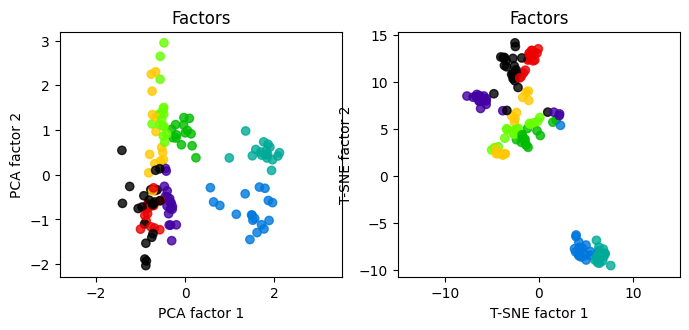

In [35]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


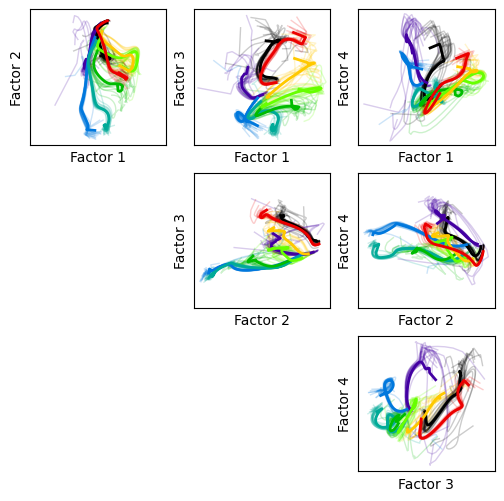

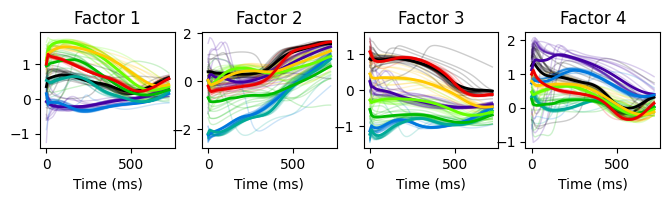

In [36]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [37]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

0.9097411299479915


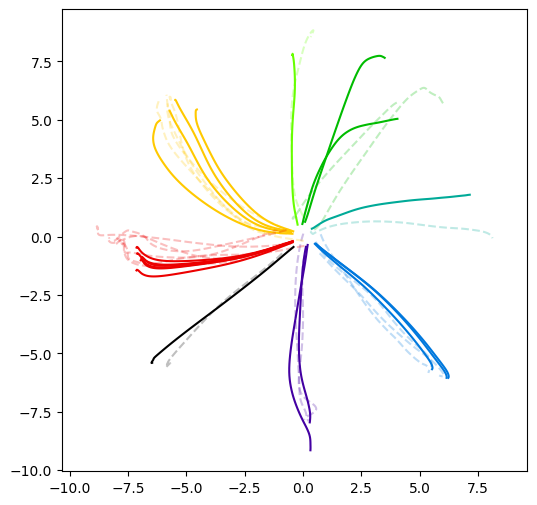

In [38]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [39]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 90.974%


## Test data

In [40]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    en_qat_model(test_neural_data.astype('float'), training=False)

Text(0.5, 1.0, 'Factors')

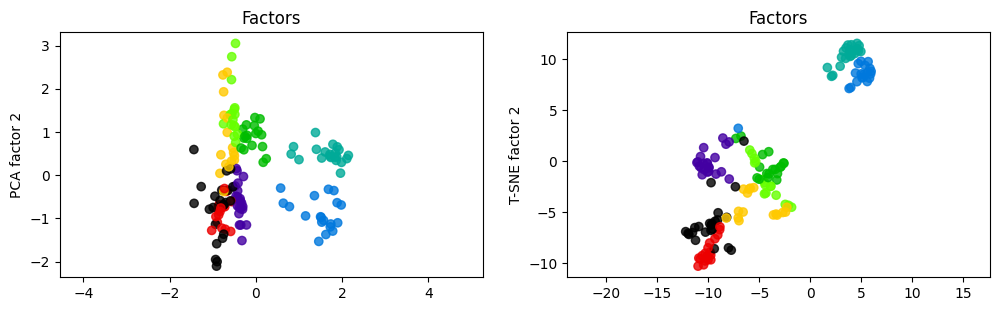

In [41]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


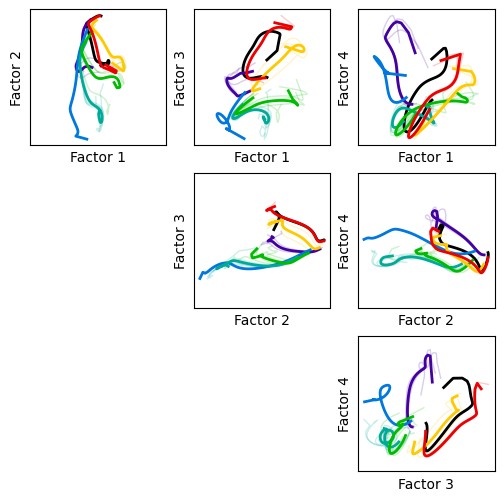

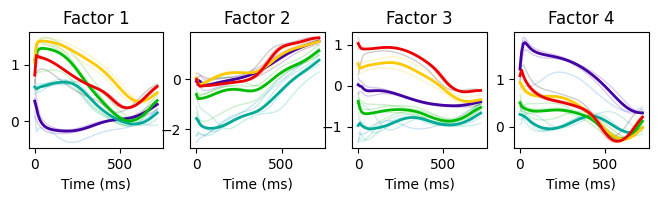

In [42]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [43]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

0.8541556993262601


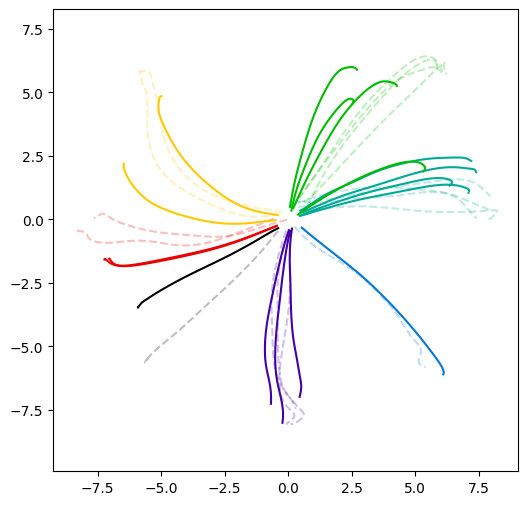

In [44]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [45]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 85.416%


# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

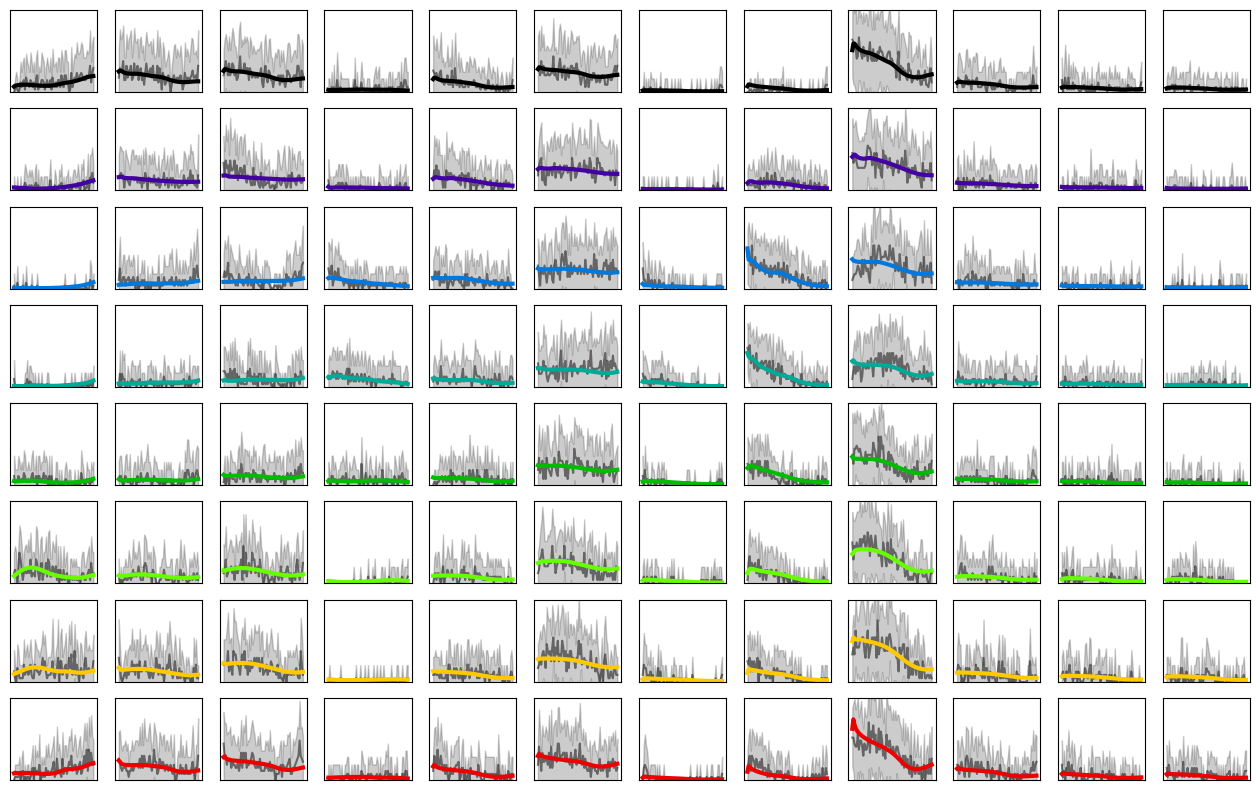

In [46]:
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]
    
    for i_n,n in enumerate(range(0,12)):
        ax = fig.add_subplot(8, 12, i*12+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
    

In [47]:
en_qat_model.summary()

Model: "lfads_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 EncoderRNN (QBidirectional)  multiple                 52224     
                                                                 
 q_act_postencoder (QActivat  multiple                 0         
 ion)                                                            
                                                                 
 dropout_13 (Dropout)        multiple                  0         
                                                                 
 dropout_14 (Dropout)        multiple                  0         
                                                                 
 DenseMean (Dense)           multiple                  8256      
                                                           

# All layers Quantized QAT

In [48]:
# qat model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [49]:
logdir = os.path.join( spike_data_dir, 'lfads_log_'+str(total_bit))
modeldir = os.path.join( spike_data_dir, 'lfads_model_'+str(total_bit))

In [50]:
T0 = datetime.now()

qat_model, x, y, validation_data, callbacks, adaptive_weights = Runtime.get_model(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-6),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed,
        quantized=True,
        total_bit=total_bit
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1000, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)

qat_model.load_model_weight(en_qat_model)



INFO:tndm.utils.logging:Seed was set to 0


Seed was set to 0


In [51]:
# freeze the encoder

lfads_layers = [
    # encoder
    #"initial_dropout",
    "encoder",
    #"dropout_post_encoder",
    #"dense_mean",
    #"dense_logvar",
    #"sampling",
    
    # decoder    
    #"decoder",
    #"dropout_post_decoder",
    #"dense",
    #"neural_dense"
]

if all_quantized_retrain:
    # Set specified layers as non-trainable
    for layer_attr in lfads_layers:
        layer = getattr(qat_model, layer_attr, None)
        if layer is not None:
            layer.trainable = False
            print(layer_attr ," is setted as non-trainable")
        else:
            print(layer_attr ," is not found")

    qat_model.summary()
    for l in qat_model.layers:
        print("{} is trainable: {}".format(l.name, l.trainable))
    
    history = qat_model.fit(
        x=x,
        y=y,
        callbacks=callbacks,
        shuffle=True,
        epochs=200,
        batch_size=16,
        validation_data=validation_data,
        verbose=2
    )

    qat_model.save(modeldir)

    print('Training took '+str(datetime.now()-T0))

encoder  is setted as non-trainable
Model: "lfads_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_15 (Dropout)        multiple                  0         
                                                                 
 EncoderRNN (QBidirectional)  multiple                 52224     
                                                                 
 q_act_postencoder (QActivat  multiple                 0         
 ion)                                                            
                                                                 
 dropout_16 (Dropout)        multiple                  0         
                                                                 
 dropout_17 (Dropout)        multiple                  0         
                                                                 
 DenseMean (QDense)          multiple                  8256      
                       

/home/pcslab/anaconda3/envs/lfads_hls4ml/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 - 31s - loss: 2008.2500 - loss/loglike: 2005.1838 - loss/kldiv: 15.3206 - loss/reg: 124.5556 - loss/reconstruction: 2005.1838 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0020 - learning_rate: 0.0010 - val_loss: 1986.5490 - val_loss/loglike: 1984.5476 - val_loss/kldiv: 10.0067 - val_loss/reconstruction: 1984.5476 - lr: 0.0010 - 31s/epoch - 3s/step
Epoch 2/200
9/9 - 31s - loss: 1996.6831 - loss/loglike: 1993.5818 - loss/kldiv: 15.4777 - loss/reg: 123.8502 - loss/reconstruction: 1993.5818 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0065 - learning_rate: 0.0010 - val_loss: 1978.1680 - val_loss/loglike: 1976.1729 - val_loss/kldiv: 9.9760 - val_loss/reconstruction: 1976.1729 - lr: 0.0010 - 31s/epoch - 3s/step
Epoch 3/200
9/9 - 31s - loss: 1988.2723 - loss/loglike: 1985.0029 - loss/kldiv: 16.2968 - loss/reg: 123.3016 - loss/reconstruction: 1985.0029 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0110 - learning_rate: 0.0010

In [52]:
print(modeldir)
qat_model = ModelLoader.load(modeldir, model_class=LFADS)

Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_16


# Latent space

## Training data

In [53]:
log_f, (g0, mean, logvar), z =  qat_model(neural_data.astype('float'), training=False)

Text(0.5, 1.0, 'Factors')

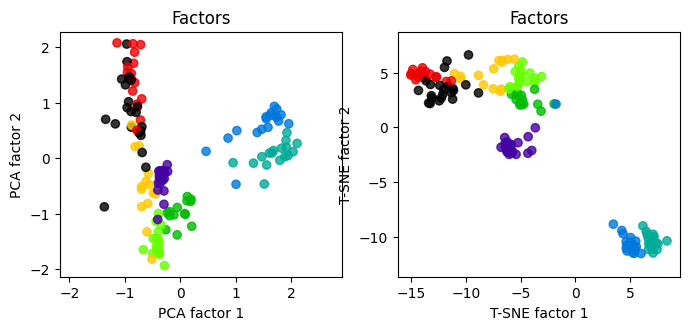

In [54]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


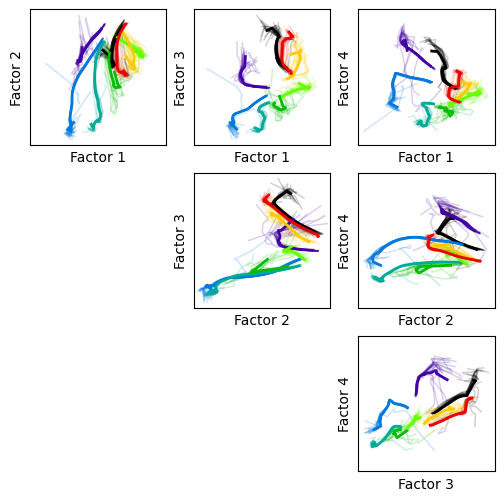

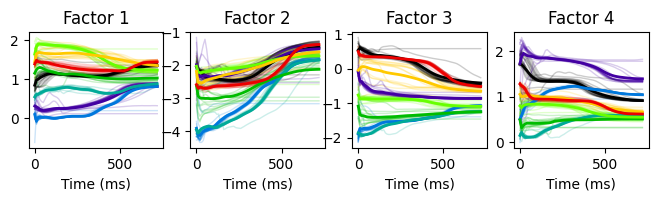

In [55]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [56]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

0.900575066012768


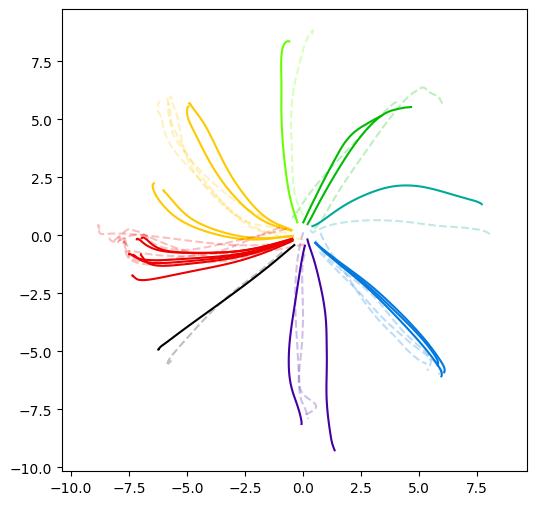

In [57]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [58]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 90.058%


## Test data

In [59]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    qat_model(test_neural_data.astype('float'), training=False)

Text(0.5, 1.0, 'Factors')

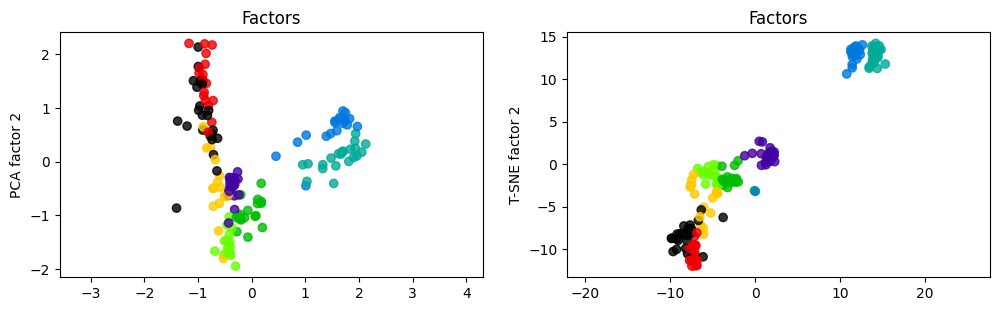

In [60]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


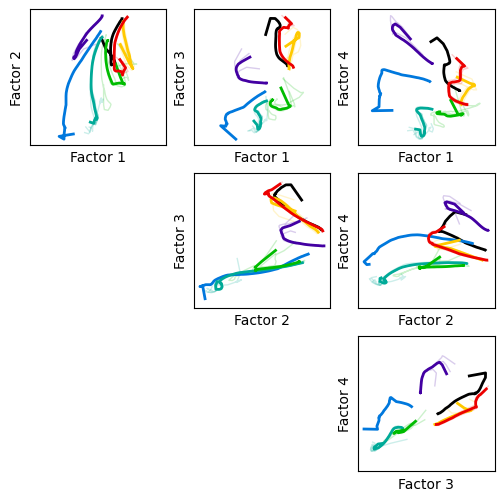

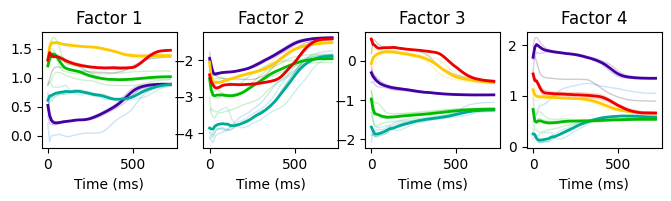

In [61]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [62]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

0.8682865928867102


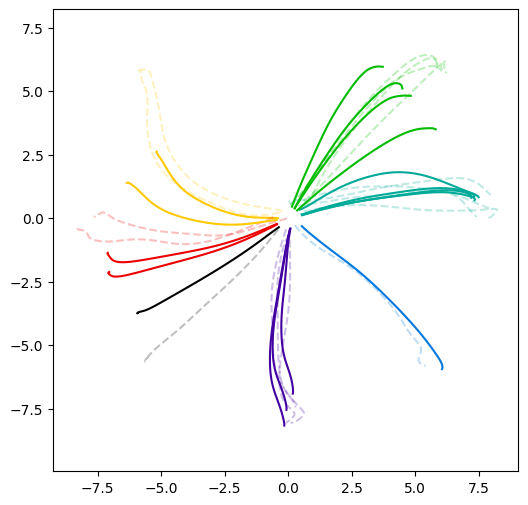

In [63]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [64]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 86.829%


# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

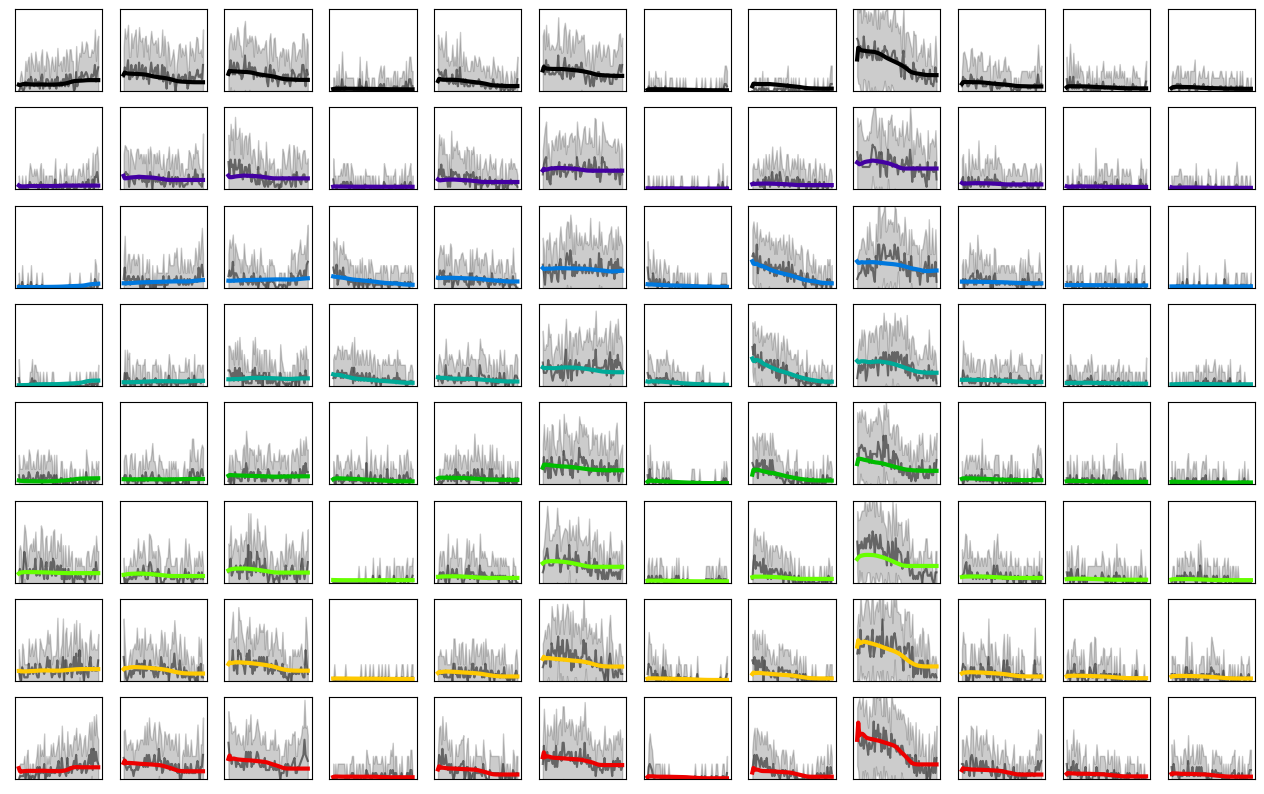

In [57]:
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]
    
    for i_n,n in enumerate(range(0,12)):
        ax = fig.add_subplot(8, 12, i*12+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
    

In [65]:
qat_model.summary()

Model: "lfads_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        multiple                  0         
                                                                 
 EncoderRNN (QBidirectional)  multiple                 52224     
                                                                 
 q_act_postencoder (QActivat  multiple                 0         
 ion)                                                            
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 dropout_20 (Dropout)        multiple                  0         
                                                                 
 DenseMean (QDense)          multiple                  8256      
                                                           

# Turn customized model to h5 format

In [66]:
decoder_dim = 64
def get_decoder_input(decoder_dim=64):
    inputs2decoder_train = tf.stack([tf.zeros_like(neural_data)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_val = tf.stack([tf.zeros_like(valid_neural_data)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_test = tf.stack([tf.zeros_like(test_neural_data)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_train = np.array(inputs2decoder_train)
    inputs2decoder_val = np.array(inputs2decoder_val)
    inputs2decoder_test = np.array(inputs2decoder_test)
    print("inputs2decoder_train shape: ", inputs2decoder_train.shape)
    print("inputs2decoder_val shape: ", inputs2decoder_val.shape)
    print("inputs2decoder_test shape: ", inputs2decoder_test.shape)
    return inputs2decoder_train, inputs2decoder_val, inputs2decoder_test
inputs2decoder_train, inputs2decoder_val, inputs2decoder_test = get_decoder_input(decoder_dim=decoder_dim)

inputs2decoder_train shape:  (136, 73, 64)
inputs2decoder_val shape:  (17, 73, 64)
inputs2decoder_test shape:  (17, 73, 64)


In [67]:
qat_model.summary()

Model: "lfads_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_18 (Dropout)        multiple                  0         
                                                                 
 EncoderRNN (QBidirectional)  multiple                 52224     
                                                                 
 q_act_postencoder (QActivat  multiple                 0         
 ion)                                                            
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 dropout_20 (Dropout)        multiple                  0         
                                                                 
 DenseMean (QDense)          multiple                  8256      
                                                           

In [68]:
from tensorflow.keras import Model
import tensorflow.keras.layers as tfl
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

In [69]:
import qkeras
from qkeras.utils import load_qmodel

In [70]:
input_shape = (73,70)
inputs = tfl.Input(shape=input_shape, name = 'encoder_input')
decode_input_shape = (73,decoder_dim)
decode_inputs = tfl.Input(shape=decode_input_shape, name = 'decoder_input')

In [71]:
encoder_GRU = qat_model.get_layer("EncoderRNN")
dense_mean = qat_model.get_layer("DenseMean")
dense_logvar = qat_model.get_layer("DenseLogVar")
decoder_GRU = qat_model.get_layer("DecoderGRU")
dense = qat_model.get_layer("Dense")
neural_dense = qat_model.get_layer("NeuralDense")
# Activation
q_act_dense_mean = qat_model.get_layer("q_act_dense_mean")
q_act_dense_logvar = qat_model.get_layer("q_act_dense_logvar")
q_act_postencoder = qat_model.get_layer("q_act_postencoder")
q_act_postsampling = qat_model.get_layer("q_act_postsampling")
q_act_predecoder = qat_model.get_layer("q_act_predecoder")
q_act_postdecoder = qat_model.get_layer("q_act_postdecoder")
q_act_postdense = qat_model.get_layer("q_act_postdense")

In [72]:
# encode
encoder_GRU_out = encoder_GRU(inputs)
q_act_postencoder_out = q_act_postencoder(encoder_GRU_out)
dense_mean_out = dense_mean(q_act_postencoder_out)
q_act_dense_mean_out = q_act_dense_mean(dense_mean_out)
dense_logvar_out = dense_logvar(q_act_postencoder_out)
q_act_dense_logvar_out = q_act_dense_logvar(dense_logvar_out)
#dense_logvar_out = tf.math.log(tf.exp(dense_logvar_out + 0.0001))

#epsilon = StandardRandomNormal()(q_act_dense_mean_out)

#z_var = ExponentLogvar()(q_act_dense_logvar_out)

#z_var = tfl.Multiply()([z_var, epsilon])

#z_out = tfl.Add()([q_act_dense_mean_out, z_var])

#q_act_postsampling_out = q_act_postsampling(z_out)
q_act_postsampling_out = q_act_postsampling(q_act_dense_mean_out)

# decode
q_act_predecoder_out = q_act_predecoder(q_act_postsampling_out)
decoder_GRU_out = decoder_GRU(decode_inputs, initial_state = q_act_predecoder_out)
q_act_postdecoder_out = q_act_postdecoder(decoder_GRU_out)
dense_out = dense(q_act_postdecoder_out)
q_act_postdense_out = q_act_postdense(dense_out)
neural_dense_out = neural_dense(q_act_postdense_out)

In [73]:
lfad_full = Model(inputs = [inputs, decode_inputs], outputs = [dense_out, neural_dense_out], name="lfad_full")

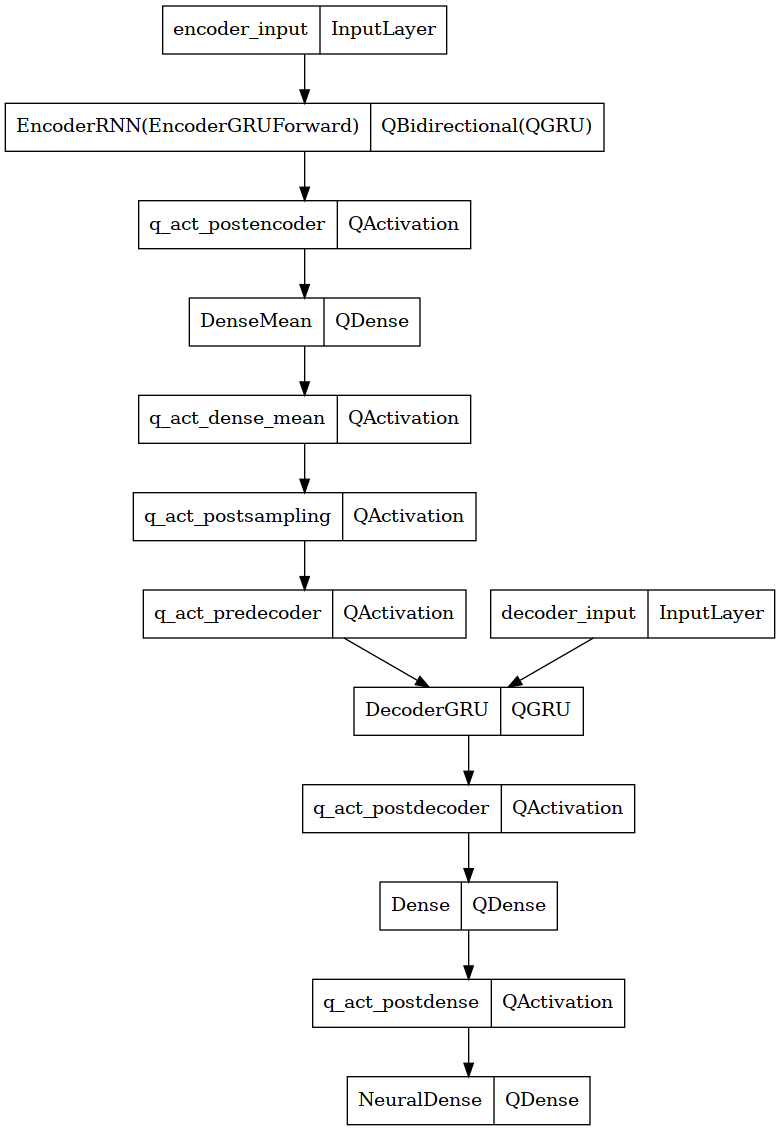

In [74]:
plot_model(lfad_full)

In [75]:
z, _ =  lfad_full.predict([neural_data.astype('float'), inputs2decoder_train])
X = np.transpose(z[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]
b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
r2 = r2_score(behavioural_data_reshape , b_reshape)
print('h5 qmodel train behaviour R2 score : {:.3%}'.format(r2))

/home/pcslab/anaconda3/envs/lfads_hls4ml/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


h5 qmodel train behaviour R2 score : 90.058%


In [76]:
pred_z_test, _ =  lfad_full.predict([test_neural_data.astype('float'), inputs2decoder_val])
Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('h5 qmodel test behaviour R2 score : {:.3%}'.format(reg.score(Xt, yt)))

/home/pcslab/anaconda3/envs/lfads_hls4ml/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


h5 qmodel test behaviour R2 score : 86.830%


In [77]:
print("model save in: "+modeldir+'.h5')
lfad_full.save(modeldir+'.h5')

model save in: Chewie_CO_FF_2016-10-07_pos_M1_spikes/lfads_model_16.h5


In [78]:
lfad_full = load_qmodel(
    modeldir+'.h5',
     compile = False
)

In [79]:
z, _ =  lfad_full.predict([neural_data.astype('float'), inputs2decoder_train])
X = np.transpose(z[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]
b_reshape = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
behavioural_data_reshape  = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
r2 = r2_score(behavioural_data_reshape , b_reshape)
print('h5 qmodel train behaviour R2 score : {:.3%}'.format(r2))

/home/pcslab/anaconda3/envs/lfads_hls4ml/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


h5 qmodel train behaviour R2 score : 90.058%


In [80]:
pred_z_test, _ =  lfad_full.predict([test_neural_data.astype('float'), inputs2decoder_val])
Xt = np.transpose(pred_z_test[:,:,factors_reconstruct], (0,2,1)).reshape((pred_z_test.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('h5 qmodel test behaviour R2 score : {:.3%}'.format(reg.score(Xt, yt)))

/home/pcslab/anaconda3/envs/lfads_hls4ml/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


h5 qmodel test behaviour R2 score : 86.830%


In [81]:
lfad_full.summary()

Model: "lfad_full"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 73, 70)]     0           []                               
                                                                                                  
 EncoderRNN (QBidirectional)    (None, 128)          52224       ['encoder_input[0][0]']          
                                                                                                  
 q_act_postencoder (QActivation  (None, 128)         0           ['EncoderRNN[0][0]']             
 )                                                                                                
                                                                                                  
 DenseMean (QDense)             (None, 64)           8256        ['q_act_postencoder[0][0]

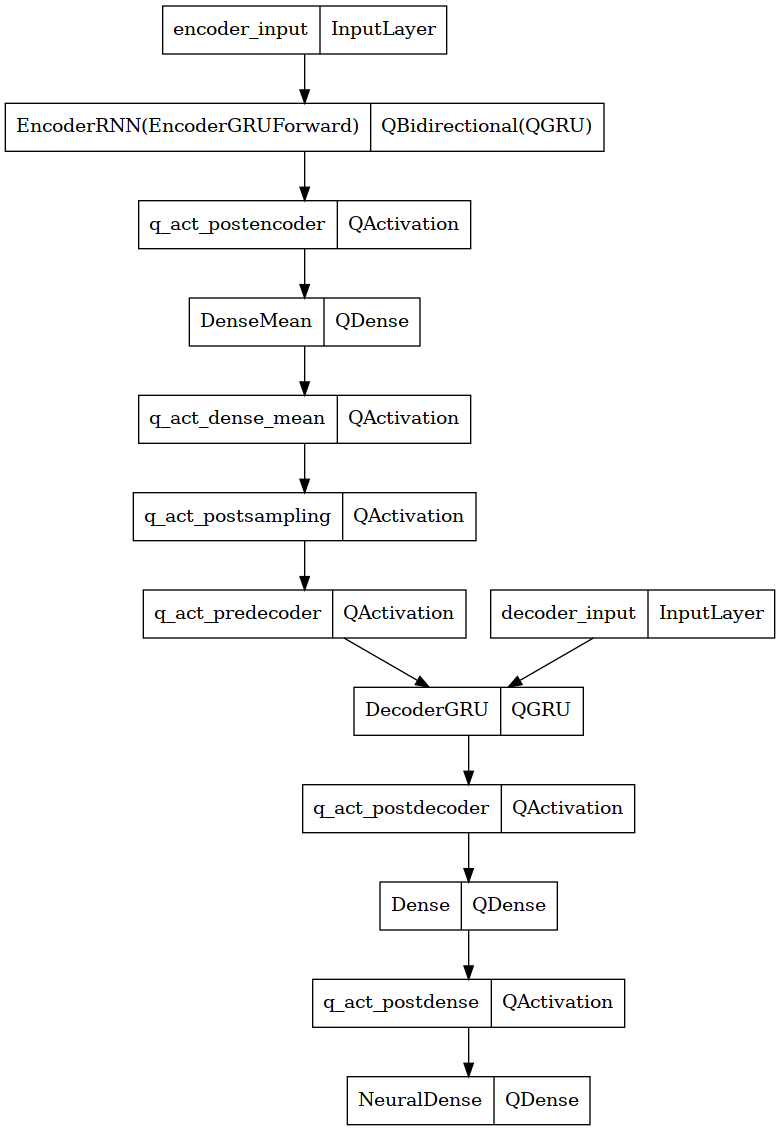

In [82]:
plot_model(lfad_full)

In [83]:
import json
import pprint

In [77]:
model_arch = json.loads(lfad_full.to_json())
layer_config = model_arch['config']['layers']

In [78]:
pprint.pprint(model_arch)

{'backend': 'tensorflow',
 'class_name': 'Functional',
 'config': {'input_layers': [['encoder_input', 0, 0], ['decoder_input', 0, 0]],
            'layers': [{'class_name': 'InputLayer',
                        'config': {'batch_input_shape': [None, 73, 70],
                                   'dtype': 'float32',
                                   'name': 'encoder_input',
                                   'ragged': False,
                                   'sparse': False},
                        'inbound_nodes': [],
                        'name': 'encoder_input'},
                       {'class_name': 'QBidirectional',
                        'config': {'backward_layer': {'class_name': 'QGRU',
                                                      'config': {'activation': {'class_name': 'quantized_tanh',
                                                                                'config': {'bits': 16,
                                                                               

In [79]:
pprint.pprint(layer_config)

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': [None, 73, 70],
             'dtype': 'float32',
             'name': 'encoder_input',
             'ragged': False,
             'sparse': False},
  'inbound_nodes': [],
  'name': 'encoder_input'},
 {'class_name': 'QBidirectional',
  'config': {'backward_layer': {'class_name': 'QGRU',
                                'config': {'activation': {'class_name': 'quantized_tanh',
                                                          'config': {'bits': 16,
                                                                     'symmetric': False,
                                                                     'use_real_tanh': False,
                                                                     'use_stochastic_rounding': False}},
                                           'activity_regularizer': None,
                                           'bias_constraint': {'class_name': 'Clip',
                                 

# HLS

In [80]:
import hls4ml

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [81]:
from hls4ml.converters.keras_to_hls import parse_default_keras_layer
from hls4ml.model.attributes import ConfigurableAttribute, TypeAttribute

In [82]:
from hls4ml.model.types import (
    #ExponentPrecisionType,
    FixedPrecisionType,
    #IntegerPrecisionType,
    RoundingMode,
    SaturationMode,
    #XnorPrecisionType,
)

# Register Layer

In [83]:
model = lfad_full

In [84]:
config = hls4ml.utils.config_from_keras_model(model, granularity='name', default_precision=hls_default_precision)
config['Model']['Strategy'] = 'Resource'

Interpreting Model
Topology:
Layer name: encoder_input, layer type: InputLayer, input shapes: [[None, 73, 70]], output shape: [None, 73, 70]
Layer name: EncoderRNN, layer type: QBidirectional, input shapes: [[None, 73, 70]], output shape: [None, 128]
Layer name: q_act_postencoder, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: DenseMean, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 64]
Layer name: q_act_dense_mean, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_act_postsampling, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: decoder_input, layer type: InputLayer, input shapes: [[None, 73, 64]], output shape: [None, 73, 64]
Layer name: q_act_predecoder, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: DecoderGRU, layer type: QGRU, input shapes: [[None, 73, 64], [None, 64]], output shape: [None, 

In [85]:
pprint.pprint(config)

{'LayerName': {'DecoderGRU': {'ApplyResetGate': 'after',
                              'Direction': 'forward',
                              'Precision': {'act': 'ap_fixed<22,6>',
                                            'activation': 'fixed<16,1,RND_CONV,SAT>',
                                            'bias': 'fixed<16,2>',
                                            'recr_act': 'ap_fixed<22,6>',
                                            'recurrent_activation': 'ufixed<16,0,RND_CONV,SAT>',
                                            'recurrent_bias': 'fixed<16,2>',
                                            'recurrent_weight': 'fixed<16,2>',
                                            'result': 'ap_fixed<22,6>',
                                            'shift': 'ap_fixed<22,6>',
                                            'slope': 'ap_fixed<22,6>',
                                            'state': 'fixed<16,7>',
                                            'weight': 'fix

In [86]:
def evaluate_NPLL(targets, pred_logrates):
    targets = tf.cast(targets, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(0.01) + pred_logrates, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(targets=targets,log_input=logrates, compute_full_loss=True)
    results = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    results = tf.reduce_mean(results) # batch mean

    return results.numpy() # negative possion loglikelihood

In [87]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir=hls_model_output_dir,
                                                       io_type = 'io_array_stream',
                                                       #io_type = 'io_parallel',
                                                       #backend='VivadoAccelerator', board='pynq-z2')
                                                       part='xcu250-figd2104-2L-e')
hls_model.compile()
#hls_model.write()

Interpreting Model
Topology:
Layer name: encoder_input, layer type: InputLayer, input shapes: [[None, 73, 70]], output shape: [None, 73, 70]
Layer name: EncoderRNN, layer type: QBidirectional, input shapes: [[None, 73, 70]], output shape: [None, 128]
Layer name: q_act_postencoder, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: DenseMean, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 64]
Layer name: q_act_dense_mean, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_act_postsampling, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: decoder_input, layer type: InputLayer, input shapes: [[None, 73, 64]], output shape: [None, 73, 64]
Layer name: q_act_predecoder, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: DecoderGRU, layer type: QGRU, input shapes: [[None, 73, 64], [None, 64]], output shape: [None, 

In [88]:
_, pred_logf_keras = lfad_full.predict([test_neural_data, inputs2decoder_test])
npll_keras = evaluate_NPLL(targets=test_neural_data, pred_logrates=pred_logf_keras)

pred_logf_hls = hls_model.predict([test_neural_data, inputs2decoder_test])
npll_hls = evaluate_NPLL(targets=test_neural_data, pred_logrates=pred_logf_hls.reshape(17,73,70))

/home/docker/.conda/envs/python3813/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [89]:
print("kears lost: ", npll_keras)
print("hls model lost: ", npll_hls)

kears lost:  1816.767
hls model lost:  1816.7826


In [90]:
from sklearn.metrics import mean_absolute_error

In [91]:
mean_absolute_error(pred_logf_keras.flatten(), pred_logf_hls.flatten())

0.0013726420625932777